In [21]:
from __future__ import annotations
import os
from pytomography.io.SPECT import simind
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM, OSMAPOSL, BSREM, KEM
from pytomography.transforms.shared import GaussianFilter
from torch import poisson
import matplotlib.pyplot as plt
import pytomography
import torch
from pytomography.callbacks import Callback
from pytomography.priors import RelativeDifferencePrior
from pytomography.priors import TopNAnatomyNeighbourWeight
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.transforms.shared import KEMTransform
from pytomography.projectors.shared import KEMSystemMatrix
import numpy as np
import torch
import pytomography
import numpy.linalg as npl
from scipy.ndimage import affine_transform, binary_erosion
from torch.optim import LBFGS
# import nibabel as nib
from pytomography.callbacks import Callback
import torch
import torch.nn as nn

torch.set_default_device('cuda:0')
pytomography.device='cuda:0'



Open data

In [22]:

path = '/home/sahamed/Projects/pytomography/scatter-estimation-deep-image-prior/simind_tutorial'
organs = ['bkg', 'liver', 'l_lung', 'r_lung', 'l_kidney', 'r_kidney','salivary', 'bladder']
activities = [2500, 450, 7, 7, 100, 100, 20, 90] # MBq
headerfiles = [os.path.join(path, 'multi_projections', organ, 'photopeak.h00') for organ in organs]
dT = 15 # seconds per projection
headerfiles_lower = [os.path.join(path, 'multi_projections', organ, 'lowerscatter.h00') for organ in organs]
headerfiles_upper = [os.path.join(path, 'multi_projections', organ, 'upperscatter.h00') for organ in organs]
projections = simind.get_projections([headerfiles, headerfiles_lower, headerfiles_upper], weights=activities)
projections_realization = torch.poisson(projections * dT)
ww_peak = simind.get_energy_window_width(headerfiles[0])
ww_lower = simind.get_energy_window_width(headerfiles_lower[0])
ww_upper = simind.get_energy_window_width(headerfiles_upper[0])
lower_scatter = projections_realization[1].unsqueeze(0)
upper_scatter = projections_realization[2].unsqueeze(0)
scatter = (lower_scatter/ww_lower+upper_scatter/ww_upper)*ww_peak/2
lower_scatter_noiseless = projections[1].unsqueeze(0) * dT
upper_scatter_noiseless = projections[2].unsqueeze(0) * dT
scatter_noiseless = (lower_scatter_noiseless/ww_lower+upper_scatter_noiseless/ww_upper)*ww_peak/2

Neural network stuff

In [23]:
def get_downward_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(), 
        ) 
    
def get_downsample_block(out_channels):
    return nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
        ) 
    
def get_bottleneck_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
        ) 
    
def get_bilinear_upsample_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same'),
        )
    
def get_upward_block(in_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(),
        )
    
def get_final_block(in_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels, 1, kernel_size=3, padding='same'),
        )
    
class UNetCustom(nn.Module):
    def __init__(self, n_channels=[2, 4, 8, 16, 32]):
        super().__init__()       
        self.downward_block1 = get_downward_block(1, n_channels[0])
        self.downward_block2 = get_downward_block(n_channels[0], n_channels[1])
        self.downward_block3 = get_downward_block(n_channels[1], n_channels[2])
        self.downward_block4 = get_downward_block(n_channels[2], n_channels[3])
        self.downsample_block1 = get_downsample_block(n_channels[0])
        self.downsample_block2 = get_downsample_block(n_channels[1])
        self.downsample_block3 = get_downsample_block(n_channels[2])
        self.downsample_block4 = get_downsample_block(n_channels[3])
        self.bottleneck_block = get_bottleneck_block(n_channels[3], n_channels[4])
        self.upsample_block1 = get_bilinear_upsample_block(n_channels[4], n_channels[3])
        self.upsample_block2 = get_bilinear_upsample_block(n_channels[3], n_channels[2])
        self.upsample_block3 = get_bilinear_upsample_block(n_channels[2], n_channels[1])
        self.upsample_block4 = get_bilinear_upsample_block(n_channels[1], n_channels[0])
        self.upward_block1 = get_upward_block(n_channels[3])
        self.upward_block2 = get_upward_block(n_channels[2])
        self.upward_block3 = get_upward_block(n_channels[1])
        self.final_block = get_final_block(n_channels[0])
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.downward_block1(x)
        x = self.downsample_block1(x1)
        x2 = self.downward_block2(x)
        x = self.downsample_block2(x2)
        x3 = self.downward_block3(x)
        x = self.downsample_block3(x3)
        x4 = self.downward_block4(x)
        x = self.downsample_block4(x4)
        x = self.bottleneck_block(x)
        x = self.upsample_block1(x) + x4
        x = self.upward_block1(x)
        x = self.upsample_block2(x) + x3
        x = self.upward_block2(x)
        x = self.upsample_block3(x) + x2
        x = self.upward_block3(x)
        x = self.upsample_block4(x) + x1
        x = self.final_block(x)
        return x

Create and train net

In [24]:
net = UNetCustom(n_channels=[8, 16, 32, 64, 128])
net

UNetCustom(
  (downward_block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (downward_block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (downward_block3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1)

In [25]:
net = UNetCustom(n_channels=[8, 16, 32, 64, 128])
truth = scatter[0,0].unsqueeze(0).unsqueeze(0)
truth = scatter[0].unsqueeze(1)
input = torch.randn(truth.shape)
optimizer_lfbgs = LBFGS(net.parameters(), lr=1, max_iter=20, history_size=100)
criterion = torch.nn.MSELoss()
def closure(optimizer):
    optimizer.zero_grad()
    NM_prediction = net(input)
    loss = criterion(NM_prediction, truth)
    loss.backward()
    return loss
for epoch in range(10):  
    loss = optimizer_lfbgs.step(lambda: closure(optimizer_lfbgs))
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Epoch 1, Loss: 4.8313212394714355
Epoch 2, Loss: 1.747843861579895
Epoch 3, Loss: 1.6110175848007202
Epoch 4, Loss: 1.5782477855682373
Epoch 5, Loss: 1.5658915042877197
Epoch 6, Loss: 1.5593221187591553
Epoch 7, Loss: 1.5551989078521729
Epoch 8, Loss: 1.552352786064148
Epoch 9, Loss: 1.55022394657135
Epoch 10, Loss: 1.5485368967056274


Get predictions and plot

In [26]:
scatter_pred = net(input)
scatter_pred = scatter_pred.swapaxes(1,0)

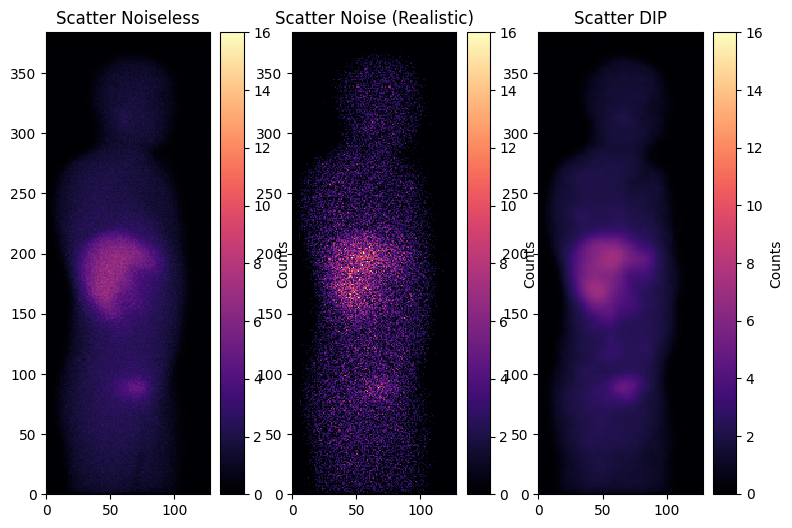

In [27]:
projection_number = 20
plt.subplots(1,3,figsize=(9,6))
plt.subplot(131)
plt.pcolormesh(scatter_noiseless[0,projection_number].cpu().T,  cmap='magma', vmax=16)
# plt.axis('off')
plt.colorbar(label = 'Counts')
plt.title('Scatter Noiseless')
plt.subplot(132)
plt.pcolormesh(scatter[0,projection_number].cpu().T,  cmap='magma', vmax=16)
# plt.axis('off')
plt.colorbar(label = 'Counts')
plt.title('Scatter Noise (Realistic)')
plt.subplot(133)
plt.pcolormesh(scatter_pred[0,projection_number].cpu().detach().T,  cmap='magma', vmax=16)
# plt.axis('off')
plt.colorbar(label = 'Counts')
plt.title('Scatter DIP')
plt.show()

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


def upconv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


class UNetCustom1(nn.Module):
    def __init__(self, n_channels):
        super(UNetCustom1, self).__init__()
        self.n_channels = n_channels
        self.down_convs = nn.ModuleList()
        self.up_convs = nn.ModuleList()
        self.bottleneck = conv_block(n_channels[-2], n_channels[-1])
        self.upconv = upconv_block(n_channels[-1], n_channels[-2])
        
        for i in range(len(n_channels) - 1, 0, -1):
            self.down_convs.append(conv_block(n_channels[i - 1], n_channels[i]))
            self.up_convs.append(upconv_block(n_channels[i] * 2, n_channels[i - 1]))

        self.final_conv = nn.Conv2d(n_channels[0], 1, kernel_size=1)

    def forward(self, x):
        intermediates = []
        # Downward path
        for i, module in enumerate(self.down_convs):
            x = module(x)
            intermediates.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.bottleneck(x)

        # Upward path
        for i, module in enumerate(self.up_convs):
            x = module(x)
            x = torch.cat([x, intermediates[-i - 1]], dim=1)

        x = self.upconv(x)
        x = self.final_conv(x)
        return x


In [20]:
net = UNetCustom1(n_channels=[8, 16, 32, 64, 128])
truth = scatter[0,0].unsqueeze(0).unsqueeze(0)
truth = scatter[0].unsqueeze(1)
input = torch.randn(truth.shape)
optimizer_lfbgs = LBFGS(net.parameters(), lr=1, max_iter=20, history_size=100)
criterion = torch.nn.MSELoss()
def closure(optimizer):
    optimizer.zero_grad()
    NM_prediction = net(input)
    loss = criterion(NM_prediction, truth)
    loss.backward()
    return loss
for epoch in range(10):  
    loss = optimizer_lfbgs.step(lambda: closure(optimizer_lfbgs))
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

RuntimeError: Given groups=1, weight of size [128, 64, 3, 3], expected input[120, 1, 128, 384] to have 64 channels, but got 1 channels instead